In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user = pd.read_csv('user_table.csv')
user

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male
...,...,...,...,...
90395,307667,2015-03-30,Desktop,Female
90396,642989,2015-02-08,Desktop,Female
90397,659645,2015-04-13,Desktop,Male
90398,359779,2015-03-23,Desktop,Male


In [3]:
home = pd.read_csv('home_page_table.csv')
search = pd.read_csv('search_page_table.csv')
payment = pd.read_csv('payment_page_table.csv')
confirm = pd.read_csv('payment_confirmation_table.csv')

In [4]:
home.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [5]:
search.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [6]:
payment.head()

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [7]:
confirm.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


## Show overall number of users in each stage

In [8]:
print("There're %d people who hit the home page" % (home.shape[0]))
print("There're %d people who hit the search page, which account for %.2f of users from the last step" % (search.shape[0], search.shape[0]/home.shape[0]))
print("There're %d people who hit the payment page, which account for %.2f of users from the last step" % (payment.shape[0], payment.shape[0]/search.shape[0]))
print("There're %d people who hit the confirm page, which account for %.2f of users from the last step" % (confirm.shape[0], confirm.shape[0]/payment.shape[0]))

There're 90400 people who hit the home page
There're 45200 people who hit the search page, which account for 0.50 of users from the last step
There're 6030 people who hit the payment page, which account for 0.13 of users from the last step
There're 452 people who hit the confirm page, which account for 0.07 of users from the last step


## A full picture of funnel conversion rate for both desktop and mobile

In [9]:
# merge tables together
from functools import reduce
all_user = reduce(lambda left,right: pd.merge(left, right, how='left', on='user_id'), [user, home, search])
all_user = all_user.rename(columns={"page_x": "home_page", "page_y": "search_page"})
all_user = reduce(lambda left,right: pd.merge(left, right, how='left', on='user_id'), [all_user, payment, confirm])
all_user = all_user.rename(columns={"page_x": "payment_page", "page_y": "confirm_page"})

all_user = all_user.replace(['home_page', 'search_page', 'payment_page', 'payment_confirmation_page'], 1.0)
all_user = all_user.fillna(0)
all_user

,user_id,date,device,sex,home_page,search_page,payment_page,confirm_page
0,450007,2015-02-28,Desktop,Female,1.0,0.0,0.0,0.0
1,756838,2015-01-13,Desktop,Male,1.0,0.0,0.0,0.0
2,568983,2015-04-09,Desktop,Male,1.0,1.0,0.0,0.0
3,190794,2015-02-18,Desktop,Female,1.0,1.0,0.0,0.0
4,537909,2015-01-15,Desktop,Male,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
90395,307667,2015-03-30,Desktop,Female,1.0,0.0,0.0,0.0
90396,642989,2015-02-08,Desktop,Female,1.0,1.0,0.0,0.0
90397,659645,2015-04-13,Desktop,Male,1.0,1.0,0.0,0.0
90398,359779,2015-03-23,Desktop,Male,1.0,0.0,0.0,0.0


In [10]:
device_df = all_user.drop(['user_id'], axis=1).groupby('device').sum().reset_index()
device_df

,device,home_page,search_page,payment_page,confirm_page
0,Desktop,60200.0,30100.0,3010.0,150.0
1,Mobile,30200.0,15100.0,3020.0,302.0


In [11]:
devide_conv = device_df.groupby('device').apply(lambda x: 
                                                pd.DataFrame([[x.search_page.mean()/x.home_page.mean(), 
                                                               x.payment_page.mean()/x.search_page.mean(), 
                                                               x.confirm_page.mean()/x.payment_page.mean()]],
                                                             columns=['search_conv','paymen_conv','confirm_conv'])).reset_index().drop(['level_1'], axis=1)
devide_conv

,device,search_conv,paymen_conv,confirm_conv
0,Desktop,0.5,0.1,0.049834
1,Mobile,0.5,0.2,0.100000


In [12]:
## We can find out that the payment page conversion rate and the payment confirmation conversion rate 
## is much higher in mobile than in desktop

## Insights on what the product team should focus on

### Gender difference

In [13]:
gender_df = all_user.drop(['user_id'], axis=1).groupby('sex').sum().reset_index()
gender_df

,sex,home_page,search_page,payment_page,confirm_page
0,Female,45075.0,22676.0,3100.0,241.0
1,Male,45325.0,22524.0,2930.0,211.0


In [14]:
gender_conv = gender_df.groupby('sex').apply(lambda x: 
                                                pd.DataFrame([[x.search_page.mean()/x.home_page.mean(), 
                                                               x.payment_page.mean()/x.search_page.mean(), 
                                                               x.confirm_page.mean()/x.payment_page.mean()]],
                                                             columns=['search_conv','paymen_conv','confirm_conv'])).reset_index().drop(['level_1'], axis=1)
gender_conv

,sex,search_conv,paymen_conv,confirm_conv
0,Female,0.503073,0.136708,0.077742
1,Male,0.496944,0.130083,0.072014


In [15]:
## We can find out that the conversion rate are higher for women than for men

### Date difference

In [16]:
# Create the month variable
import datetime as dt

all_user['date'] = pd.to_datetime(all_user['date'])
all_user['month'] = all_user['date'].dt.month
all_user['weekday'] = all_user['date'].dt.weekday
all_user['weekofyear'] = all_user['date'].dt.weekofyear

In [17]:
all_user

,user_id,date,device,sex,home_page,search_page,payment_page,confirm_page,month,weekday,weekofyear
0,450007,2015-02-28,Desktop,Female,1.0,0.0,0.0,0.0,2,5,9
1,756838,2015-01-13,Desktop,Male,1.0,0.0,0.0,0.0,1,1,3
2,568983,2015-04-09,Desktop,Male,1.0,1.0,0.0,0.0,4,3,15
3,190794,2015-02-18,Desktop,Female,1.0,1.0,0.0,0.0,2,2,8
4,537909,2015-01-15,Desktop,Male,1.0,0.0,0.0,0.0,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...
90395,307667,2015-03-30,Desktop,Female,1.0,0.0,0.0,0.0,3,0,14
90396,642989,2015-02-08,Desktop,Female,1.0,1.0,0.0,0.0,2,6,6
90397,659645,2015-04-13,Desktop,Male,1.0,1.0,0.0,0.0,4,0,16
90398,359779,2015-03-23,Desktop,Male,1.0,0.0,0.0,0.0,3,0,13


#### Month

In [18]:
month_df = all_user.drop(['user_id'], axis=1).groupby('month').sum().reset_index()
month_df

,month,home_page,search_page,payment_page,confirm_page,weekday,weekofyear
0,1,22600.0,13554.0,2390.0,189.0,69715,70820
1,2,22600.0,13687.0,2412.0,173.0,68455,166027
2,3,22600.0,8879.0,631.0,44.0,65850,261870
3,4,22600.0,9080.0,597.0,46.0,67208,360111


In [19]:
month_conv = all_user.groupby('month').apply(lambda x: 
                                                pd.DataFrame([[x.search_page.mean()/x.home_page.mean(), 
                                                               x.payment_page.mean()/x.search_page.mean(), 
                                                               x.confirm_page.mean()/x.payment_page.mean()]],
                                                             columns=['search_conv','paymen_conv','confirm_conv'])).reset_index().drop(['level_1'], axis=1)
month_conv

,month,search_conv,paymen_conv,confirm_conv
0,1,0.599735,0.176332,0.079079
1,2,0.605619,0.176226,0.071725
2,3,0.392876,0.071067,0.069731
3,4,0.401770,0.065749,0.077052


/Users/hengyuai/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


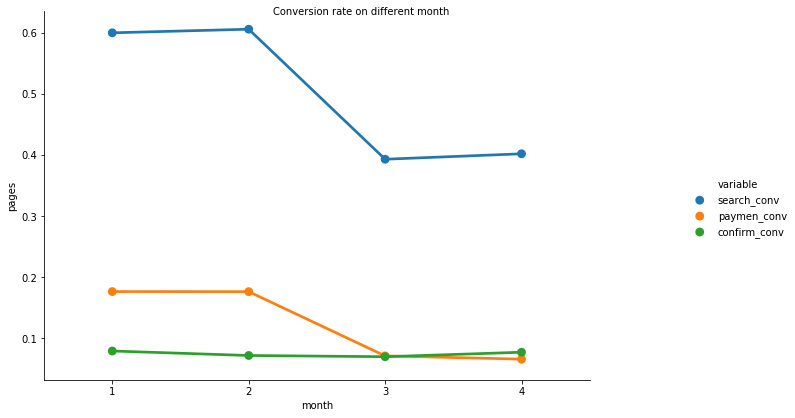

In [20]:
month_df = pd.melt(month_conv, id_vars=['month'], value_vars=['search_conv', 'paymen_conv', 'confirm_conv'],  value_name='pages')

f = sns.factorplot(x="month", y="pages", hue="variable", data=month_df)
f.fig.suptitle('Conversion rate on different month', fontsize= 10)
f.fig.set_size_inches(12, 6)

In [21]:
# Home-page to search-page conversion rate was higher in the 1st and 2nd month and lower in the 3rd and 4th month 
# Search-page to payment-page conversion rate was higher in the 1st and the 2nd months and lower in the 3rd and 4th month
# Payment-page to confirm-page conversion rate was higher in the 1st and the 4th months and lower in the 2nd and 3rd month 

#### Weekday

In [22]:
weekday_df = all_user.drop(['user_id'], axis=1).groupby('weekday').sum()
weekday_df

,home_page,search_page,payment_page,confirm_page,month,weekofyear
weekday,,,,,,
0,12955.0,6483.0,869.0,77.0,32688,129111
1,12697.0,6252.0,853.0,69.0,32080,126691
2,12831.0,6335.0,838.0,54.0,33241,128475
3,13444.0,6717.0,899.0,66.0,33573,127877
4,12750.0,6406.0,871.0,54.0,30960,115558
5,12801.0,6545.0,845.0,70.0,30862,115100
6,12922.0,6462.0,855.0,62.0,32596,116016


In [23]:
weekday_conv = all_user.groupby('weekday').apply(lambda x: 
                                                pd.DataFrame([[x.search_page.mean()/x.home_page.mean(), 
                                                               x.payment_page.mean()/x.search_page.mean(), 
                                                               x.confirm_page.mean()/x.payment_page.mean()]],
                                                             columns=['search_conv','paymen_conv','confirm_conv'])).reset_index().drop(['level_1'],axis=1)
weekday_conv

,weekday,search_conv,paymen_conv,confirm_conv
0,0,0.500425,0.134043,0.088608
1,1,0.492400,0.136436,0.080891
2,2,0.493726,0.132281,0.064439
3,3,0.499628,0.133840,0.073415
4,4,0.502431,0.135966,0.061998
5,5,0.511288,0.129106,0.082840
6,6,0.500077,0.132312,0.072515


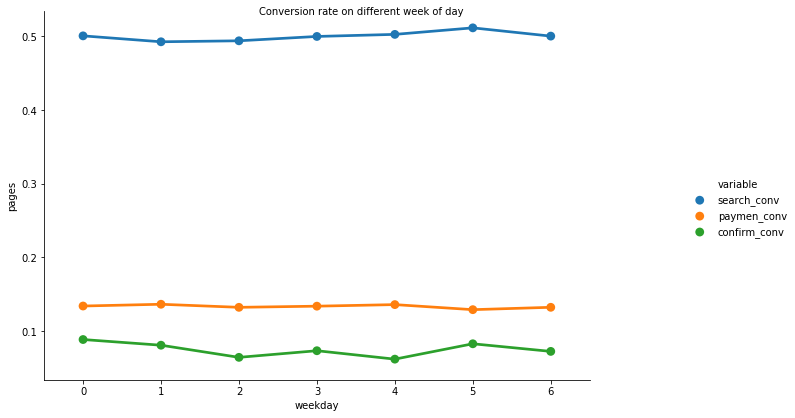

In [24]:
weekday_df = pd.melt(weekday_conv, id_vars=['weekday'], value_vars=['search_conv', 'paymen_conv', 'confirm_conv'],  value_name='pages')

f = sns.factorplot(x="weekday", y="pages", hue="variable", data=weekday_df)
f.fig.suptitle('Conversion rate on different week of day', fontsize= 10)
f.fig.set_size_inches(12, 6)

In [25]:
# Conversion rate was lower in Monday and Tuesday and higher in Friday, Saturday and Sunday

#### Week of year

In [26]:
weekofyear_df = all_user.drop(['user_id'], axis=1).groupby('weekofyear').sum()
weekofyear_df

,home_page,search_page,payment_page,confirm_page,month,weekday
weekofyear,,,,,,
1,2906.0,1752.0,300.0,25.0,2906,13098
2,5087.0,3021.0,506.0,47.0,5087,15214
3,5037.0,3050.0,523.0,35.0,5037,14909
4,5221.0,3088.0,596.0,49.0,5221,15613
5,5177.0,3162.0,558.0,40.0,6005,15849
6,5773.0,3480.0,602.0,46.0,11546,17517
7,5565.0,3354.0,592.0,39.0,11130,16781
8,5612.0,3404.0,617.0,43.0,11224,17076
9,5544.0,3213.0,527.0,38.0,11810,16445


In [27]:
weekofyear_conv = all_user.groupby('weekofyear').apply(lambda x: 
                                                pd.DataFrame([[x.search_page.mean()/x.home_page.mean(), 
                                                               x.payment_page.mean()/x.search_page.mean(), 
                                                               x.confirm_page.mean()/x.payment_page.mean()]],
                                                             columns=['search_conv','paymen_conv','confirm_conv'])).reset_index().drop(['level_1'],axis=1)
weekofyear_conv

,weekofyear,search_conv,paymen_conv,confirm_conv
0,1,0.602891,0.171233,0.083333
1,2,0.593867,0.167494,0.092885
2,3,0.605519,0.171475,0.066922
3,4,0.591458,0.193005,0.082215
4,5,0.610778,0.176471,0.071685
5,6,0.602806,0.172989,0.076412
6,7,0.602695,0.176506,0.065878
7,8,0.606557,0.181257,0.069692
8,9,0.579545,0.164021,0.072106
9,10,0.387166,0.078054,0.090909


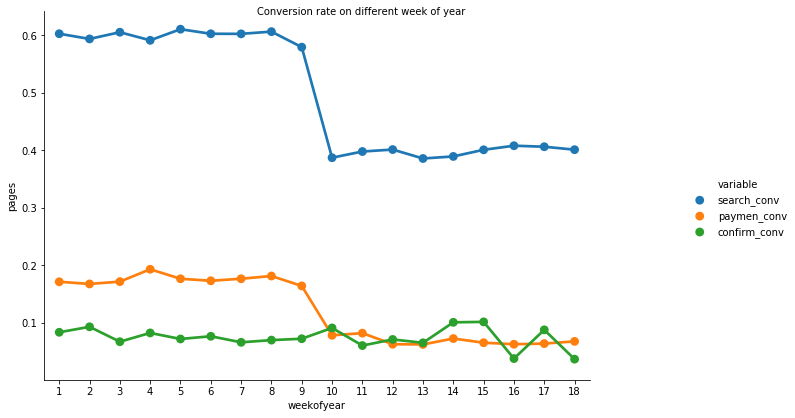

In [28]:
weekofyear_df = pd.melt(weekofyear_conv, id_vars=['weekofyear'], value_vars=['search_conv', 'paymen_conv', 'confirm_conv'],  value_name='pages')

f = sns.factorplot(x="weekofyear", y="pages", hue="variable", data=weekofyear_df)
f.fig.suptitle('Conversion rate on different week of year', fontsize= 10)
f.fig.set_size_inches(12, 6)

In [29]:
# Home-page to search-page conversion rate and Search-page to payment-page conversion rate decreased sharply in week 10
# Payment-page to confirm-page conversion rate decreased sharply in week 16 and week 18
# which both need investigation.

## Statistical Test

In [30]:
all_user['converted'] = (all_user.confirm_page == 1).astype(int)
all_user['weekday_name'] = all_user['date'].dt.weekday_name
convert = all_user.drop(['user_id', 'date', 'home_page', 'search_page', 'payment_page', 'confirm_page', 'weekofyear', 'weekday'], axis=1)
convert

,device,sex,month,converted,weekday_name
0,Desktop,Female,2,0,Saturday
1,Desktop,Male,1,0,Tuesday
2,Desktop,Male,4,0,Thursday
3,Desktop,Female,2,0,Wednesday
4,Desktop,Male,1,0,Thursday
...,...,...,...,...,...
90395,Desktop,Female,3,0,Monday
90396,Desktop,Female,2,0,Sunday
90397,Desktop,Male,4,0,Monday
90398,Desktop,Male,3,0,Monday


In [31]:
convert = pd.get_dummies(convert, prefix='',prefix_sep='')
convert = convert.astype(int)
convert.head()

,month,converted,Desktop,Mobile,Female,Male,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2,0,1,0,1,0,0,0,1,0,0,0,0
1,1,0,1,0,0,1,0,0,0,0,0,1,0
2,4,0,1,0,0,1,0,0,0,0,1,0,0
3,2,0,1,0,1,0,0,0,0,0,0,0,1
4,1,0,1,0,0,1,0,0,0,0,1,0,0


In [32]:
y = convert.converted
X = convert.drop(['converted'], axis=1)

In [33]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=20,
                            min_samples_split=20)
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

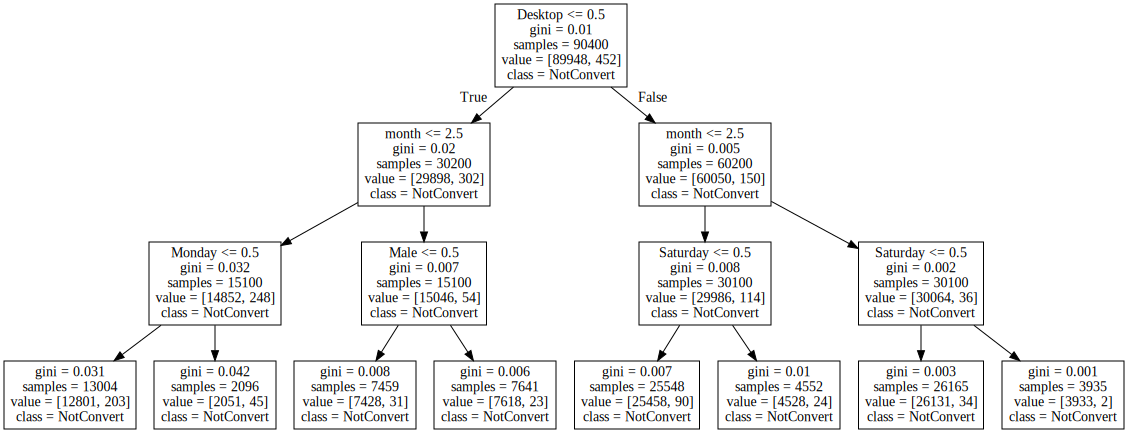

In [34]:
import graphviz
from IPython.display import display
from sklearn import tree
display(
    graphviz.Source(
        tree.export_graphviz(dt,
                             feature_names=X.columns,
                             class_names=['NotConvert', 'Converted'])))